In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [1]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
from hyperparams import Hyperparams as params
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
from dcttsModel import C,Cs,Css,D,HC,TextEnc,AudioEnc,AudioDec,Text2Mel,SSRN
# reload(dcttsModel)

In [2]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [3]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

LOADED EPOCH 211, LOSS 0.026198864983978557, BEST LOSS 0.026198864983978557


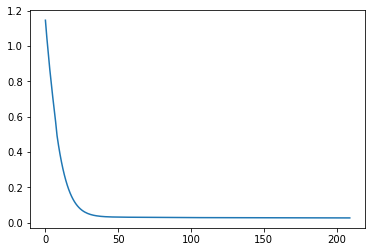

In [22]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load == 2:
    startEpoch,lossHist,bestLoss = loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev,best=1)
if load == 1:
    startEpoch,lossHist,bestLoss = loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev,best=0)
else:
    # COLD START - RESET text2Mel
    audioDec = AudioDec(d=params.d,F=params.F).to(dev)
    text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

LOADED EPOCH 101, LOSS 0.09999311505191362, BEST LOSS 0.09999311505191362


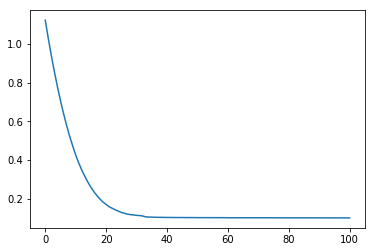

In [23]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load == 2:
    startEpoch,lossHist,bestLoss = loadChkpt(ssrn,ssrnOpt,'ssrn',dev,best=1)
elif load == 1:
    startEpoch,lossHist,bestLoss = loadChkpt(ssrn,ssrnOpt,'ssrn',dev,best=0)
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

In [24]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(1)
L,S,Y = L.unsqueeze(0),S.unsqueeze(0),Y.unsqueeze(0)
L.shape,S.shape,Y.shape

(torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]))

In [25]:
print(ch.cuda.is_available())
print(dev)
dev = 'cpu'
print(dev)
text2Mel = text2Mel.eval().to(dev)
# audioDec = audioDec.eval().to(dev)
ssrn = ssrn.eval().to(dev)

True
cpu
cpu


In [26]:
# # text = "Bears. Beets. Battlestar Galactica".lower()
# text = "four score and seven years ago".lower()
# # text = "how cow brown now".lower()
# L = ch.Tensor([params.c2i[c] for c in text])
# L = ch.cat((L,ch.zeros(180-L.shape[0])))
# L = L.type(ch.LongTensor).to(dev).unsqueeze(0)

In [27]:
# initial audio enc
# S = ch.zeros((80,217)).to(dev).unsqueeze(0)
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
Shat = s0

In [28]:
with ch.no_grad():
    for t in tqdm.tqdm_notebook(range(100)):
        Snext,A = text2Mel(L,Shat[:,:,-100:])
#         S[:,:,t+1 ] = Shat[:,:,t]
        Shat = ch.cat((s0,Snext),dim=2)
#         S = ch.cat((S,Shat[:,:,-1:]),dim=2)

In [29]:
Yhat = ssrn(Shat)

In [30]:
def toAudio(Y):
    T = Y ** (params.eta / params.gamma) * 50
    T = T.cpu().detach().numpy().astype(np.float64)
    T = T[0].T
    T[T<0] = 0

    lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
    T = lwsProc.run_lws(T)
    T = lwsProc.istft(T)
    return T

In [31]:
ipd.Audio(toAudio(Y),rate=22050)

In [32]:
ipd.Audio(toAudio(Yhat),rate=22050)

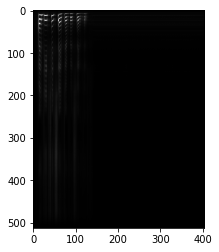

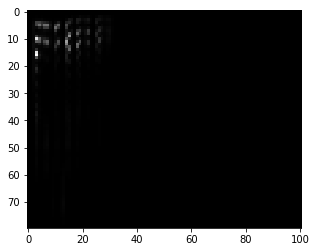

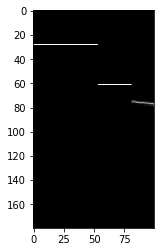

In [33]:
plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()

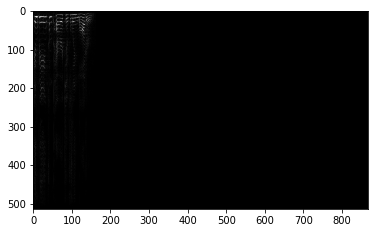

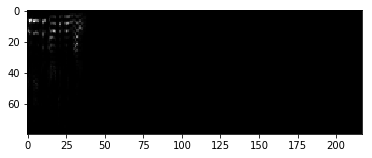

In [34]:
plt.imshow(Y[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()